In [65]:
!pip install matplotlib networkx scipy scikit-learn

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import eigh

class GraphLearningSGA:
    def __init__(self, alpha=0.01, gamma=100, max_iter=50, tol=1e-4, epsilon=1e-3):
        self.alpha = alpha
        self.gamma = gamma
        self.max_iter = max_iter
        self.tol = tol
        self.epsilon = epsilon
        self.w_ = None
        self.L_ = None
        self.A_ = None

    def _L_operator(self, w, p, iu):
        """Opérateur Laplacien L(w)."""
        L = np.zeros((p, p))
        L[iu] = -w
        L = L + L.T
        np.fill_diagonal(L, -np.sum(L, axis=1))
        return L

    def _A_operator(self, w, p, iu):
        """Opérateur Adjacence A(w)."""
        A = np.zeros((p, p))
        A[iu] = w
        A = A + A.T
        return A

    def _L_adjoint(self, M, p, iu):
        """Adjoint de l'opérateur Laplacien L*(M)."""
        diag = np.diag(M)
        return diag[iu[0]] + diag[iu[1]] - 2 * M[iu]

    def _A_adjoint(self, M, iu):
        """Adjoint de l'opérateur Adjacence A*(M)."""
        return 2 * M[iu]

    def fit(self, S):
        p = S.shape[0]
        n_edges = p * (p - 1) // 2
        iu = np.triu_indices(p, k=1)
        
        # Initialisation "Naive" (S^-1) souvent meilleure que random pour la convergence
        # On prend la valeur absolue de l'inverse de la covariance comme point de départ
        try:
            S_inv = np.linalg.pinv(S)
            w = np.abs(S_inv[iu])
        except:
            w = np.random.uniform(0.1, 1.0, n_edges)
        
        # J matrix
        J = (1.0 / p) * np.ones((p, p))

        # Initialisation spectrale
        A_init = self._A_operator(w, p, iu)
        psi, V = eigh(A_init)
        
        for t in range(self.max_iter):
            w_old = w.copy()
            
            # --- Matrices courantes ---
            Lw = self._L_operator(w, p, iu)
            Aw = self._A_operator(w, p, iu)
            
            # --- Mises à jour spectrales (V et psi) ---
            evals_temp, V = eigh(Aw)
            idx = np.argsort(evals_temp)[::-1]
            psi = evals_temp[idx]
            V = V[:, idx]
            
            # Projection Bipartite (Symétrie)
            psi_sym = np.zeros_like(psi)
            half = p // 2
            for i in range(half):
                val = (psi[i] - psi[p - 1 - i]) / 2.0
                psi_sym[i] = val
                psi_sym[p - 1 - i] = -val
            if p % 2 != 0: psi_sym[half] = 0
            psi = np.sort(psi_sym)[::-1] # Isotonic

            # --- Mise à jour de w (Gradient) ---
            try:
                inv_term = np.linalg.pinv(Lw + J)
            except:
                inv_term = np.linalg.pinv(Lw + J + 1e-6 * np.eye(p))
            
            # 1. Gradient des données (S) : C'EST LE TERME MANQUANT
            # Il pousse w à diminuer si la covariance S est forte
            grad_S = (1.0 / self.gamma) * self._L_adjoint(S, p, iu)
            
            # 2. Gradient du Log-Det (Inverse)
            # Il pousse w à augmenter pour garder la matrice définie positive
            # Attention au signe : on soustrait ce terme dans le gradient global
            grad_inv = (1.0 / self.gamma) * self._L_adjoint(inv_term, p, iu)
            
            # 3. Gradient Spectral (Structure Bipartite)
            M_spectral = V @ np.diag(psi) @ V.T
            grad_spectral = self._A_adjoint(Aw, iu) - self._A_adjoint(M_spectral, iu)
            
            # 4. Gradient Sparsité
            grad_sparsity = (self.alpha / self.gamma) * (1.0 / (self.epsilon + w))
            
            # COMBINAISON (MLE : S - inv)
            # On cherche S - inv = 0. Donc le gradient est (S - inv) + penalités
            grad = (grad_S - grad_inv) + grad_spectral + grad_sparsity
            
            # Pas de descente
            L_const = 2.0 + (1.0 / self.gamma) 
            
            # Mise à jour projetée
            w = np.maximum(0, w - (1.0 / L_const) * grad)

            # Convergence
            diff = np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-10)
            if diff < self.tol:
                print(f"Convergence à l'itération {t}")
                break
        
        self.w_ = w
        self.L_ = self._L_operator(w, p, iu)
        self.A_ = self._A_operator(w, p, iu)
        return self


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import eigh

class GraphLearningSGA:
    def __init__(self, alpha=0.01, gamma=100, max_iter=50, tol=1e-4, epsilon=1e-3):
        self.alpha = alpha
        self.gamma = gamma
        self.max_iter = max_iter
        self.tol = tol
        self.epsilon = epsilon
        self.w_ = None
        self.L_ = None
        self.A_ = None

    def _L_operator(self, w, p, iu):
        """Opérateur Laplacien L(w)."""
        L = np.zeros((p, p))
        L[iu] = -w
        L = L + L.T
        np.fill_diagonal(L, -np.sum(L, axis=1))
        return L

    def _A_operator(self, w, p, iu):
        """Opérateur Adjacence A(w)."""
        A = np.zeros((p, p))
        A[iu] = w
        A = A + A.T
        return A

    def _L_adjoint(self, M, p, iu):
        """Adjoint de l'opérateur Laplacien L*(M)."""
        diag = np.diag(M)
        return diag[iu[0]] + diag[iu[1]] - 2 * M[iu]

    def _A_adjoint(self, M, iu):
        """Adjoint de l'opérateur Adjacence A*(M)."""
        return 2 * M[iu]

    def fit(self, S):
        p = S.shape[0]
        n_edges = p * (p - 1) // 2
        iu = np.triu_indices(p, k=1)
        
        # Initialisation "Naive" (S^-1) souvent meilleure que random pour la convergence
        # On prend la valeur absolue de l'inverse de la covariance comme point de départ
        try:
            S_inv = np.linalg.pinv(S)
            w = np.abs(S_inv[iu])
        except:
            w = np.random.uniform(0.1, 1.0, n_edges)
        
        # J matrix
        J = (1.0 / p) * np.ones((p, p))
        K = S + 2*np.eye(p) - np.ones((p,p))

        # Initialisation spectrale
        A_init = self._A_operator(w, p, iu)
        psi, V = eigh(A_init)
        
        for t in range(self.max_iter):
            w_old = w.copy()
            
            # --- Matrices courantes ---
            Lw = self._L_operator(w, p, iu)
            Aw = self._A_operator(w, p, iu)
            
            # --- Mises à jour spectrales (V et psi) ---
            evals_temp, V = eigh(Aw)
            idx = np.argsort(evals_temp)[::-1]
            psi = evals_temp[idx]
            V = V[:, idx]
            
            # Projection Bipartite (Symétrie)
            psi_sym = np.zeros_like(psi)
            half = p // 2
            for i in range(half):
                val = (psi[i] - psi[p - 1 - i]) / 2.0
                psi_sym[i] = val
                psi_sym[p - 1 - i] = -val
            if p % 2 != 0: psi_sym[half] = 0
            psi = np.sort(psi_sym)[::-1] # Isotonic

            # --- Mise à jour de w (Gradient) ---
            try:
                inv_term = np.linalg.pinv(Lw + J)
            except:
                inv_term = np.linalg.pinv(Lw + J + 1e-6 * np.eye(p))

            grad_inv = (1.0 / self.gamma) * self._L_adjoint(inv_term, p, iu)
            M_spectral = V @ np.diag(psi) @ V.T
            grad_spectral = self._A_adjoint(Aw,iu)
            grad_c = self._A_adjoint(M_spectral,iu) - (1/self.gamma)* self._L_adjoint(K,p,iu)
            
            grad = grad_inv + grad_spectral - grad_c
            
            # Pas de descente
            L_const = 2*p 
            
            # Mise à jour projetée
            w = np.maximum(0, w - (1.0 / L_const) * grad)

            # Convergence
            diff = np.linalg.norm(w - w_old) / (np.linalg.norm(w_old) + 1e-10)
            if diff < self.tol:
                print(f"Convergence à l'itération {t}")
                break
    
        self.w_ = w
        self.L_ = self._L_operator(w, p, iu)
        self.A_ = self._A_operator(w, p, iu)
        return self


In [2]:
from sklearn.metrics import f1_score

def evaluate_graph_performance(W_true, W_learned, threshold=1e-5):
    """
    Calcule l'Erreur Relative (RE) et le F-score (FS) selon le papier.
    
    Args:
        W_true (np.array): La vraie matrice d'adjacence (Ground Truth).
        W_learned (np.array): La matrice apprise par l'algo.
        threshold (float): Valeur en dessous de laquelle une arête est considérée comme inexistante (0).
        
    Returns:
        dict: {'RE': float, 'FS': float}
    """
    # 1. Préparation : On ne garde que le triangle supérieur (sans la diagonale)
    # car les matrices sont symétriques.
    p = W_true.shape[0]
    iu = np.triu_indices(p, k=1)
    
    w_true_vec = W_true[iu]
    w_learned_vec = W_learned[iu]
    
    # 2. Calcul de l'Erreur Relative (RE) 
    # On compare les valeurs continues des poids
    diff_norm = np.linalg.norm(w_learned_vec - w_true_vec)
    true_norm = np.linalg.norm(w_true_vec)
    
    if true_norm == 0:
        re = 0.0 if diff_norm == 0 else np.inf
    else:
        re = diff_norm / true_norm

    # 3. Calcul du F-score (FS) [cite: 765]
    # On binarise les arêtes : 1 si poids > threshold, 0 sinon
    bin_true = (np.abs(w_true_vec) > threshold).astype(int)
    bin_learned = (np.abs(w_learned_vec) > threshold).astype(int)
    
    # Le calcul manuel de tp, fp, fn pour coller à la formule du papier :
    tp = np.sum((bin_true == 1) & (bin_learned == 1))
    fp = np.sum((bin_true == 0) & (bin_learned == 1))
    fn = np.sum((bin_true == 1) & (bin_learned == 0))
    
    denom = 2*tp + fp + fn
    if denom == 0:
        fs = 1.0 # Cas vide parfait
    else:
        fs = (2 * tp) / denom

    return {"RE": re, "FS": fs}


In [3]:
def make_block_k_component_laplacian(p=64, k=4, w_low=0.0, w_high=1.0, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)

    sizes = [p // k] * k
    assert sum(sizes) == p

    W_true = np.zeros((p, p), dtype=float)
    start = 0
    for sz in sizes:
        idx = np.arange(start, start + sz)
        W = rng.uniform(w_low, w_high, size=(sz, sz))
        W = 0.5 * (W + W.T)
        np.fill_diagonal(W, 0.0)
        W_true[np.ix_(idx, idx)] = W
        start += sz

    Theta_true = laplacian_from_W(W_true)
    return W_true, Theta_true

def make_er_noise_laplacian(p=64, p_edge=0.25, kappa=0.45, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)

    M = (rng.random((p, p)) < p_edge).astype(float)
    M = np.triu(M, 1)
    M = M + M.T

    W_er = rng.uniform(0.0, kappa, size=(p, p))
    W_er = 0.5 * (W_er + W_er.T)
    np.fill_diagonal(W_er, 0.0)
    W_er = M * W_er

    Theta_er = laplacian_from_W(W_er)
    return W_er, Theta_er

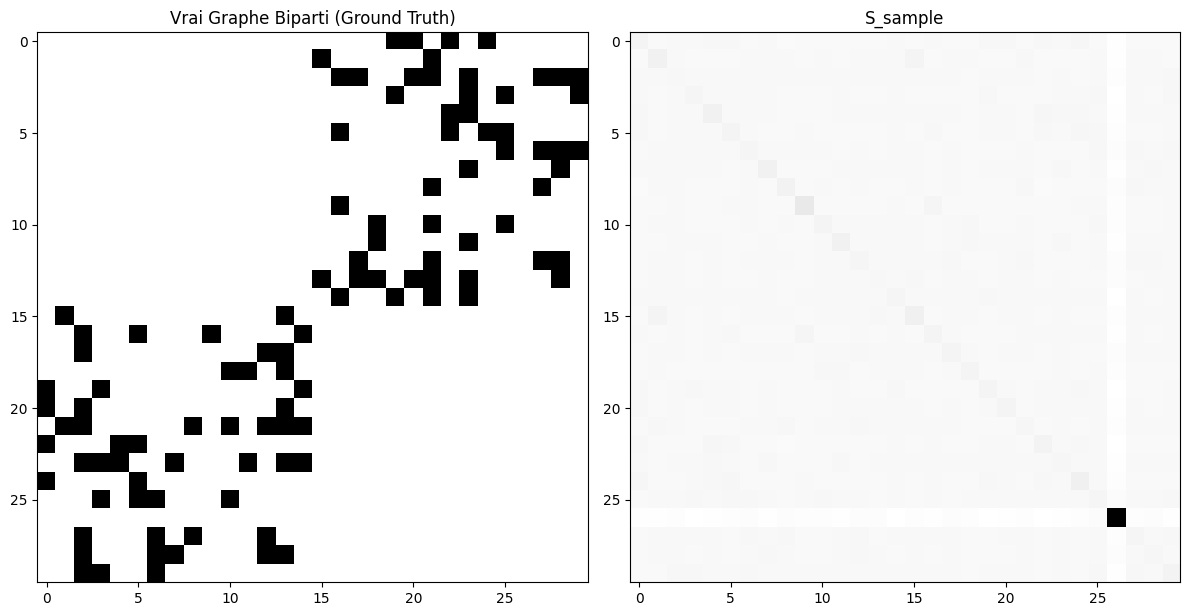

In [4]:
import numpy as np
import networkx as nx
from scipy.linalg import pinv, eigh
import matplotlib.pyplot as plt

# 1. GÉNÉRATION D'UN VRAI GRAPHE BIPARTI SPARSE
# ---------------------------------------------

n_nodes = 30
n1, n2 = 15, 15  # Deux groupes de 15 noeuds
# Probabilité de connexion faible (0.2) pour avoir un graphe sparse
G_true = nx.bipartite.random_graph(n1, n2, p=0.2, seed=42)
W_true = nx.to_numpy_array(G_true) 

# Création de la matrice de Précision (Laplacien + Regularisation)
# Theta = L_true + petite valeur diag pour inversibilité
L_true = np.diag(np.sum(W_true, axis=1)) - W_true
Theta_true = L_true + 1e-1 * np.eye(n_nodes)

# 2. SIMULATION DES DONNÉES (GMRF)
# --------------------------------
# On génère des échantillons X ~ N(0, Theta^-1) 
n_samples = 1000 # Nombre d'observations
Cov_true = pinv(Theta_true) # Inverse de la précision = Covariance vraie
# Génération des données multivariées
X = np.random.multivariate_normal(mean=np.zeros(n_nodes), cov=Cov_true, size=n_samples)
# Calcul de la Matrice de Covariance Empirique (S)
S_sample = np.cov(X.T) 

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Vrai Graphe Biparti (Ground Truth)")
plt.imshow(W_true, cmap='Greys')

plt.subplot(1, 2, 2)
plt.title(f"S_sample")
plt.imshow(S_sample, cmap='Greys')

plt.tight_layout()
plt.show()

Lancement de la Grid Search sur 12 combinaisons...
Testing: alpha=0.01, gamma=10 ...Convergence à l'itération 146
 -> FS: 0.0000
Testing: alpha=0.05, gamma=10 ...Convergence à l'itération 146
 -> FS: 0.0000
Testing: alpha=0.1, gamma=10 ...Convergence à l'itération 146
 -> FS: 0.0000
Testing: alpha=0.01, gamma=50 ... -> FS: 0.9905
Testing: alpha=0.05, gamma=50 ... -> FS: 0.9905
Testing: alpha=0.1, gamma=50 ... -> FS: 0.9905
Testing: alpha=0.01, gamma=100 ... -> FS: 0.9905
Testing: alpha=0.05, gamma=100 ... -> FS: 0.9905
Testing: alpha=0.1, gamma=100 ... -> FS: 0.9905
Testing: alpha=0.01, gamma=500 ... -> FS: 0.9298
Testing: alpha=0.05, gamma=500 ... -> FS: 0.9298
Testing: alpha=0.1, gamma=500 ... -> FS: 0.9298

MEILLEURE COMBINAISON TROUVÉE
Alpha : 0.01
Gamma : 50.0
F-score : 0.9905
Relative Error : 0.5053
Convergence à l'itération 725


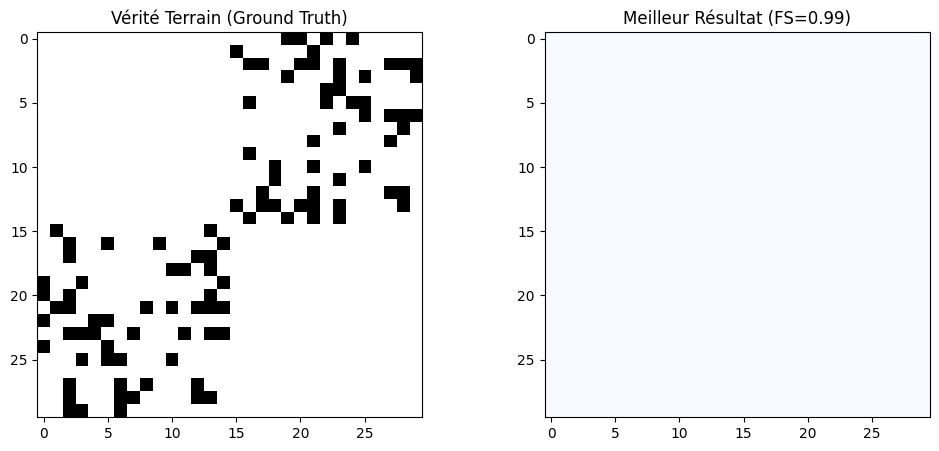

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Pour un joli tableau de résultats

# On définit une plage de recherche
# On baisse drastiquement gamma pour redonner de la voix aux données
alphas = [0.01, 0.05, 0.1]
gammas = [10, 50, 100, 500] 

results = []

print(f"Lancement de la Grid Search sur {len(alphas)*len(gammas)} combinaisons...")

for g in gammas:
    for a in alphas:
        print(f"Testing: alpha={a}, gamma={g} ...", end="")
        
        # On réinitialise l'algo à chaque fois
        # Note: on réduit tolérance et iter pour aller vite lors du scan
        model = GraphLearningSGA(alpha=a, gamma=g, max_iter=300, tol=1e-4)
        model.fit(S_sample)
        
        # Nettoyage
        W_clean = model.A_.copy()
        W_clean[W_clean < 1e-3] = 0
        
        # Mesure
        met = evaluate_graph_performance(W_true, W_clean, threshold=0.2)
        
        print(f" -> FS: {met['FS']:.4f}")
        
        results.append({
            'alpha': a,
            'gamma': g,
            'FS': met['FS'],
            'RE': met['RE']
        })

# --- Affichage des Meilleurs Résultats ---
df_res = pd.DataFrame(results)
best_run = df_res.loc[df_res['FS'].idxmax()]

print("\n" + "="*40)
print(f"MEILLEURE COMBINAISON TROUVÉE")
print("="*40)
print(f"Alpha : {best_run['alpha']}")
print(f"Gamma : {best_run['gamma']}")
print(f"F-score : {best_run['FS']:.4f}")
print(f"Relative Error : {best_run['RE']:.4f}")

# --- Visualisation du Meilleur Graphe ---
# On relance le meilleur modèle pour l'afficher proprement
best_model = GraphLearningSGA(alpha=best_run['alpha'], gamma=best_run['gamma'], max_iter=1000, tol=1e-5)
best_model.fit(S_sample)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Vérité Terrain (Ground Truth)")
plt.imshow(W_true, cmap='Greys')
plt.subplot(1, 2, 2)
plt.title(f"Meilleur Résultat (FS={best_run['FS']:.2f})")
plt.imshow(best_model.A_, cmap='Blues')
plt.show()

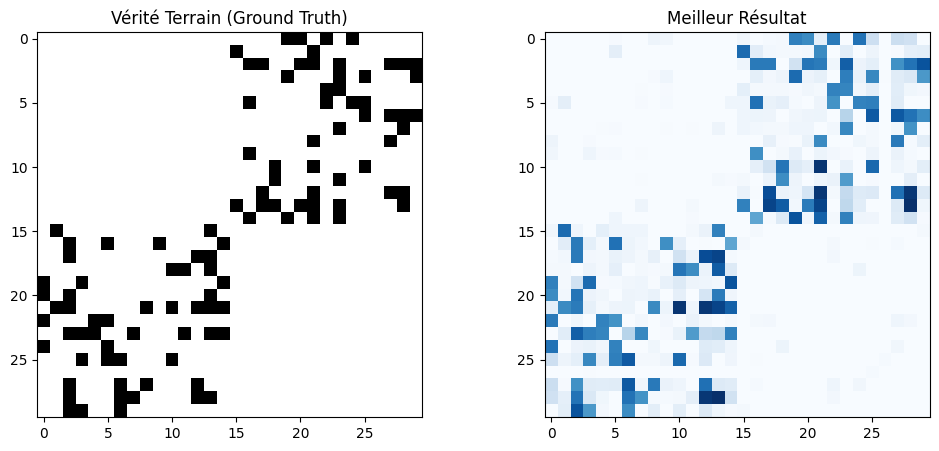

In [31]:

# --- Visualisation du Meilleur Graphe ---
# On relance le meilleur modèle pour l'afficher proprement
best_model = GraphLearningSGA(alpha=0.01, gamma=1e4, max_iter=1000, tol=1e-5)
best_model.fit(S_sample)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Vérité Terrain (Ground Truth)")
plt.imshow(W_true, cmap='Greys')
plt.subplot(1, 2, 2)
plt.title(f"Meilleur Résultat")
plt.imshow(best_model.A_, cmap='Blues')
plt.show()

In [27]:
met = evaluate_graph_performance(W_true, best_model.A_, threshold=0.2)
        
print(f" -> FS: {met['FS']:.4f}")

 -> FS: 0.9138


Démarrage du Stress-Test (Resistance au Bruit)...
Test avec niveau de bruit : 0.0 ... F-score : 0.918
Test avec niveau de bruit : 0.5 ... F-score : 0.504
Test avec niveau de bruit : 1.0 ... F-score : 0.368
Test avec niveau de bruit : 1.5 ... F-score : 0.362
Test avec niveau de bruit : 2.0 ... F-score : 0.302


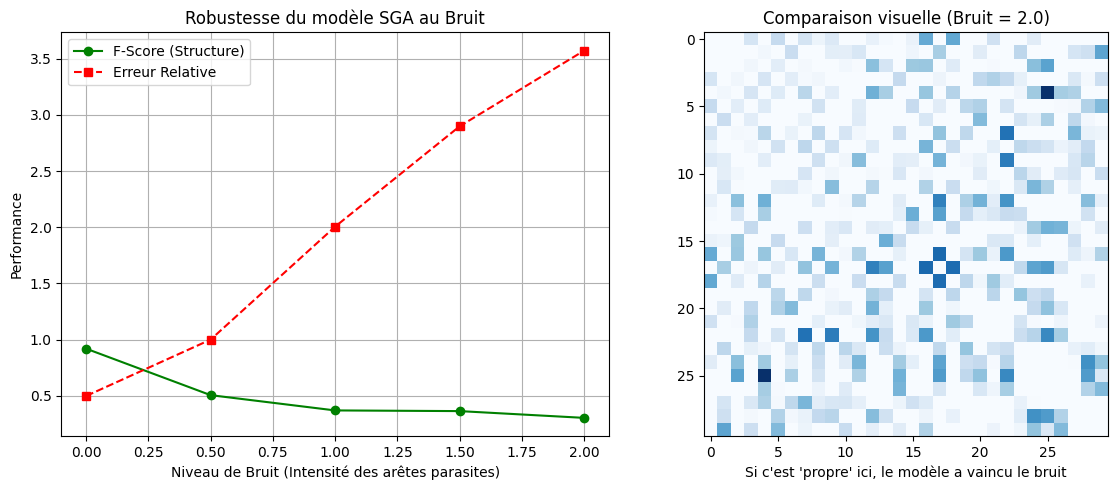

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import pinv, eigh

def generate_noisy_bipartite_data(n1, n2, noise_level, n_samples=500):
    """
    Génère une covariance S à partir d'un graphe biparti corrompu par du bruit.
    """
    n_nodes = n1 + n2
    
    # 1. Vrai Graphe Biparti (Signal)
    # Probabilité de connexion interne faible pour que ce soit sparse
    G_clean = nx.bipartite.random_graph(n1, n2, p=0.3, seed=42)
    W_clean = nx.to_numpy_array(G_clean)
    
    # 2. Ajout de Bruit Structurel (Symétrique !)
    # On crée une matrice de bruit aléatoire
    np.random.seed(None) # Random seed changeante
    N = np.random.rand(n_nodes, n_nodes)
    N = (N + N.T) / 2.0 # Symétrisation impérative
    np.fill_diagonal(N, 0) # Pas de boucles sur soi-même
    
    # On ajoute ce bruit au graphe propre
    # noise_level contrôle l'intensité des fausses arêtes
    W_noisy = W_clean + noise_level * N
    
    # Note : W_noisy n'est PLUS biparti maintenant (il a des arêtes partout)
    
    # 3. Construction du Laplacien et Précision
    L_noisy = np.diag(np.sum(W_noisy, axis=1)) - W_noisy
    # On ajoute une diagonale pour inversibilité (conditionnement)
    Theta = L_noisy + 1e-2 * np.eye(n_nodes)
    
    # 4. Génération des données (GMRF)
    Cov_true = pinv(Theta)
    X = np.random.multivariate_normal(np.zeros(n_nodes), Cov_true, size=n_samples)
    S = np.cov(X.T)
    
    return S, W_clean, W_noisy

# --- PARAMÈTRES DU TEST ---
noise_levels = [0.0, 0.5, 1.0, 1.5, 2.0] # De pas de bruit à bruit très fort
f_scores = []
re_scores = []

n1, n2 = 15, 15
fixed_alpha = 0.05
fixed_gamma = 100 # Gamma modéré pour laisser parler les données bruitées

print(f"Démarrage du Stress-Test (Resistance au Bruit)...")

for level in noise_levels:
    print(f"Test avec niveau de bruit : {level} ... ", end="")
    
    # 1. Génération
    S_noisy, W_clean, W_noisy_true = generate_noisy_bipartite_data(n1, n2, noise_level=level)
    
    # 2. Apprentissage (SGA)
    # On utilise l'algo avec le correctif du gradient (assurez-vous d'avoir la classe corrigée chargée)
    model = GraphLearningSGA(alpha=fixed_alpha, gamma=fixed_gamma, max_iter=500, tol=1e-4)
    model.fit(S_noisy)
    
    # 3. Nettoyage et Mesure
    W_learned = model.A_.copy()
    W_learned[W_learned < 1e-3] = 0
    
    # IMPORTANT : On compare le graphe appris avec le graphe PROPRE (W_clean)
    # On veut savoir si l'algo a retrouvé le signal caché sous le bruit.
    metrics = evaluate_graph_performance(W_clean, W_learned, threshold=1e-3)
    
    f_scores.append(metrics['FS'])
    re_scores.append(metrics['RE'])
    print(f"F-score : {metrics['FS']:.3f}")

# --- VISUALISATION DES RÉSULTATS ---
plt.figure(figsize=(12, 5))

# Courbe de performance
plt.subplot(1, 2, 1)
plt.plot(noise_levels, f_scores, 'o-', color='green', label='F-Score (Structure)')
plt.plot(noise_levels, re_scores, 's--', color='red', label='Erreur Relative')
plt.title("Robustesse du modèle SGA au Bruit")
plt.xlabel("Niveau de Bruit (Intensité des arêtes parasites)")
plt.ylabel("Performance")
plt.legend()
plt.grid(True)

# Exemple visuel du pire cas (Dernier niveau testé)
plt.subplot(1, 2, 2)
plt.title(f"Comparaison visuelle (Bruit = {noise_levels[-1]})")
# On superpose : Vert = Vrai, Rouge = Appris (Approximation)
# Ou mieux : afficher juste l'appris pour voir s'il est resté biparti
plt.imshow(W_learned, cmap='Blues')
plt.xlabel("Si c'est 'propre' ici, le modèle a vaincu le bruit")

plt.tight_layout()
plt.show()

Lancement de la simulation : 8 niveaux de bruit x 20 essais.


100%|██████████| 160/160 [00:47<00:00,  3.37it/s]
/tmp/ipykernel_235899/3648047520.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_boxplot, labels=summary['Noise_Level'], patch_artist=True)



Résumé Statistique :
   Noise_Level   FS_Mean    FS_Std   RE_Mean    RE_Std
0         0.00  0.960891  0.014364  0.326197  0.038434
1         0.05  0.897223  0.012632  0.412811  0.044091
2         0.10  0.843604  0.024613  0.503359  0.045123
3         0.15  0.793616  0.020980  0.574056  0.047647
4         0.20  0.728121  0.036903  0.702351  0.068733
5         0.25  0.700152  0.039003  0.794387  0.071157
6         0.30  0.671861  0.029919  0.867450  0.058113
7         0.35  0.632219  0.027951  1.000789  0.054935


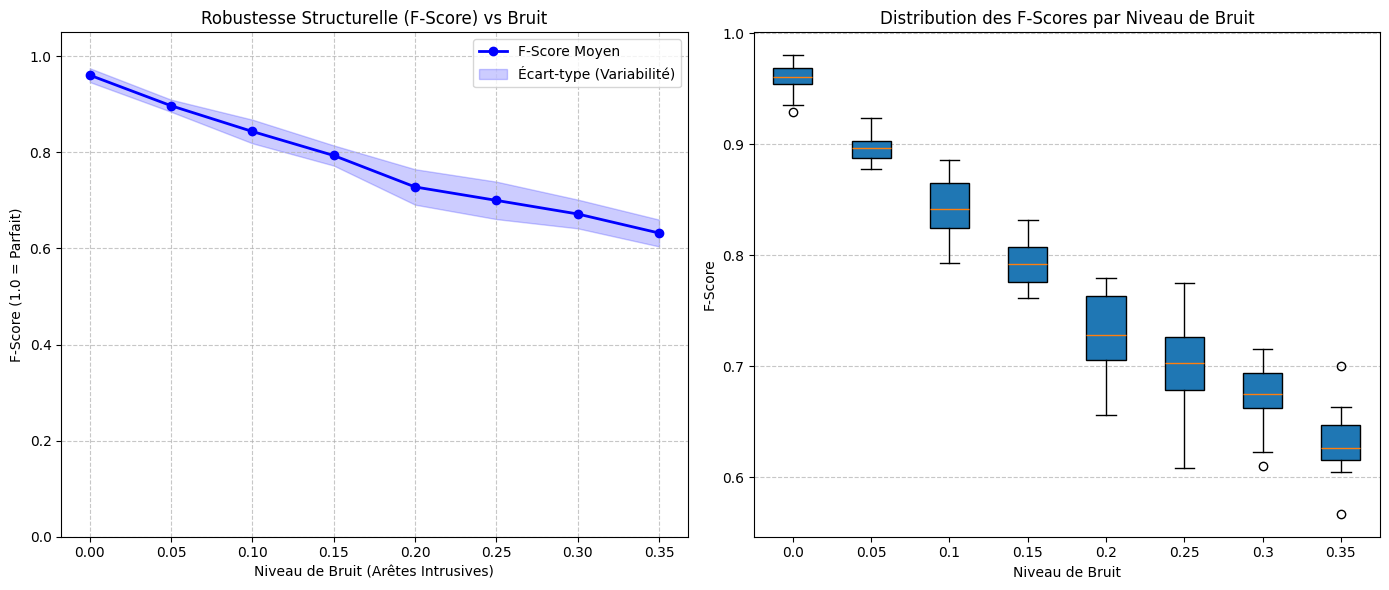

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import pinv, eigh
from tqdm import tqdm  # Pour la barre de progression

# --- RAPPEL DES FONCTIONS NÉCESSAIRES ---
# Assurez-vous d'avoir exécuté la classe GraphLearningSGA (version corrigée avec grad_S)
# et la fonction generate_noisy_bipartite_data définie précédemment.

def run_monte_carlo_experiment(n_trials=20, noise_levels=[0, 0.5, 1.0, 1.5, 2.0]):
    """
    Exécute une simulation Monte Carlo pour tester la robustesse au bruit.
    """
    results = []
    
    # Paramètres fixes du graphe
    n1, n2 = 15, 15
    
    # Paramètres de l'algo (Ceux qui marchaient bien lors du calibrage)
    # Note: On garde un gamma modéré pour laisser parler les données malgré le bruit
    model_params = {'alpha': 0.05, 'gamma': 100, 'max_iter': 300, 'tol': 1e-4}
    
    print(f"Lancement de la simulation : {len(noise_levels)} niveaux de bruit x {n_trials} essais.")
    total_runs = len(noise_levels) * n_trials
    
    with tqdm(total=total_runs) as pbar:
        for noise in noise_levels:
            for i in range(n_trials):
                # 1. Génération d'un nouveau jeu de données aléatoire
                # La seed change automatiquement à chaque appel de numpy si non fixée
                S, W_clean, W_noisy_true = generate_noisy_bipartite_data(n1, n2, noise_level=noise)
                
                # 2. Apprentissage
                model = GraphLearningSGA(**model_params)
                try:
                    model.fit(S)
                    
                    # 3. Nettoyage et Mesure
                    W_learned = model.A_.copy()
                    W_learned[W_learned < 1e-3] = 0 # Threshold
                    
                    metrics = evaluate_graph_performance(W_clean, W_learned, threshold=1e-3)
                    
                    # Stockage
                    results.append({
                        'Noise_Level': noise,
                        'Trial': i,
                        'F_Score': metrics['FS'],
                        'Relative_Error': metrics['RE'],
                        'Convergence': True
                    })
                except Exception as e:
                    # En cas de crash (matrice singulière rare), on note l'échec
                    results.append({
                        'Noise_Level': noise,
                        'Trial': i,
                        'F_Score': 0, # Penalité
                        'Relative_Error': np.nan,
                        'Convergence': False
                    })
                
                pbar.update(1)
    
    return pd.DataFrame(results)

# --- LANCEMENT DE L'EXPÉRIENCE ---
# 20 essais par niveau est un bon début pour avoir des stats fiables
df_results = run_monte_carlo_experiment(n_trials=20, noise_levels=[0.0, 0.05, 0.1, 0.15, 0.2, 0.25,0.3,0.35])

# --- ANALYSE ET VISUALISATION ---

# Calcul des moyennes et écarts-types par niveau de bruit
summary = df_results.groupby('Noise_Level').agg({
    'F_Score': ['mean', 'std'],
    'Relative_Error': ['mean', 'std']
}).reset_index()

# Simplification des noms de colonnes
summary.columns = ['Noise_Level', 'FS_Mean', 'FS_Std', 'RE_Mean', 'RE_Std']

print("\nRésumé Statistique :")
print(summary)

# CRÉATION DES GRAPHIQUES AVEC BANDES D'ERREUR
plt.figure(figsize=(14, 6))

# Graphique 1 : F-Score (Structure)
plt.subplot(1, 2, 1)
x = summary['Noise_Level']
y = summary['FS_Mean']
error = summary['FS_Std']

plt.plot(x, y, 'b-o', label='F-Score Moyen', linewidth=2)
# Zone d'écart-type (Confiance ~68%)
plt.fill_between(x, y - error, y + error, alpha=0.2, color='blue', label='Écart-type (Variabilité)')
plt.title("Robustesse Structurelle (F-Score) vs Bruit", fontsize=12)
plt.xlabel("Niveau de Bruit (Arêtes Intrusives)", fontsize=10)
plt.ylabel("F-Score (1.0 = Parfait)", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1.05)
plt.legend()

# Graphique 2 : Boxplot (Distribution complète)
# Le boxplot est souvent plus honnête que la moyenne car il montre les outliers
plt.subplot(1, 2, 2)
# On prépare les données pour le boxplot
data_for_boxplot = [df_results[df_results['Noise_Level'] == n]['F_Score'].values for n in summary['Noise_Level']]
plt.boxplot(data_for_boxplot, labels=summary['Noise_Level'], patch_artist=True)
plt.title("Distribution des F-Scores par Niveau de Bruit", fontsize=12)
plt.xlabel("Niveau de Bruit", fontsize=10)
plt.ylabel("F-Score", fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Génération du scénario: G_bi(40, 24, 0.7) + Bruit G_ER(64, 0.35)
Démarrage de l'algorithme SGA...


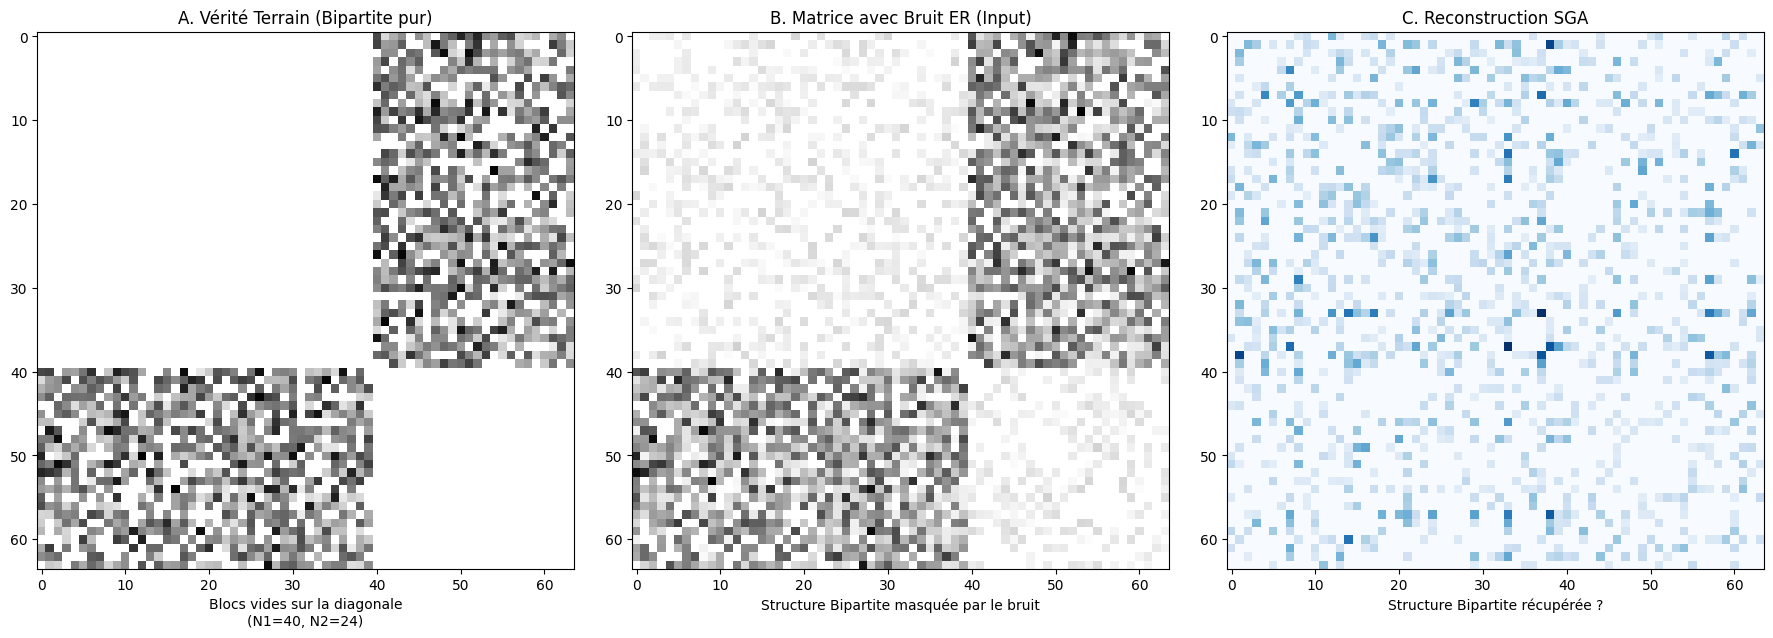

RÉSULTATS REPRODUCTION FIG. 16
F-score (Recovery)  : 0.2482
Relative Error (RE) : 0.9906


In [44]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.linalg import pinv

def run_figure16_experiment():
    # --- 1. PARAMÈTRES DU PAPIER ---
    n1, n2 = 40, 24
    p = n1 + n2
    p_bipartite = 0.70
    p_noise_er = 0.35
    n_samples = 500 # Standard pour ce genre de dimension
    
    print(f"Génération du scénario: G_bi({n1}, {n2}, {p_bipartite}) + Bruit G_ER({p}, {p_noise_er})")

    # --- 2. GÉNÉRATION DU GRAPHE BIPARTI (Ground Truth) ---
    # Structure
    G_bi = nx.bipartite.random_graph(n1, n2, p=p_bipartite, seed=42)
    W_bi = nx.to_numpy_array(G_bi)
    
    # Poids uniformes [0.1, 1] comme spécifié
    # On multiplie le masque binaire par des poids aléatoires
    weights_bi = np.random.uniform(0.1, 1.0, size=(p, p))
    weights_bi = (weights_bi + weights_bi.T) / 2.0 # Symétrie
    W_bi = W_bi * weights_bi # Application des poids
    
    # --- 3. GÉNÉRATION DU BRUIT ERDOS-RENYI ---
    # Structure de bruit
    G_er = nx.erdos_renyi_graph(p, p=p_noise_er, seed=99)
    W_er = nx.to_numpy_array(G_er)
    
    # Poids du bruit (supposons même distribution [0.1, 1] ou légèrement plus faible)
    weights_er = np.random.uniform(0, 0.35, size=(p, p))
    weights_er = (weights_er + weights_er.T) / 2.0
    W_noise_component = W_er * weights_er
    
    # --- 4. CRÉATION DU GRAPHE "OBSERVÉ" (Bruité) ---
    # C'est la matrice de précision qui contient le bruit
    W_total_noisy = W_bi + W_noise_component
    # Note : W_total_noisy n'est PAS biparti. Il a des arêtes partout.
    
    # Construction du Laplacien bruité pour générer les données
    L_noisy = np.diag(np.sum(W_total_noisy, axis=1)) - W_total_noisy
    Theta_noisy = L_noisy
    
    # Génération des données X ~ N(0, Theta^-1)
    Cov_noisy = pinv(Theta_noisy)
    X = np.random.multivariate_normal(np.zeros(p), Cov_noisy, size=n_samples)
    S = np.cov(X.T) + 1/3 *np.eye(p)
    
    # --- 5. APPRENTISSAGE SGA ---
    print("Démarrage de l'algorithme SGA...")
    # Paramètres suggérés pour ce niveau de bruit fort :
    # Gamma élevé pour forcer le nettoyage du bruit ER
    # Alpha modéré pour gérer la sparsité
    model = GraphLearningSGA(alpha=0.1, gamma=10000, max_iter=500, tol=1e-5)
    model.fit(S)
    
    W_learned = model.A_
    
    # --- 6. VISUALISATION (Style Figure 16) ---
    plt.figure(figsize=(18, 6))
    
    # A. Ground Truth (Ce qu'on veut retrouver)
    plt.subplot(1, 3, 1)
    plt.title("A. Vérité Terrain (Bipartite pur)")
    plt.imshow(W_bi, cmap='Greys', interpolation='nearest')
    plt.xlabel(f"Blocs vides sur la diagonale\n(N1={n1}, N2={n2})")
    
    # B. Noisy Precision (La réalité des données)
    plt.subplot(1, 3, 2)
    plt.title("B. Matrice avec Bruit ER (Input)")
    plt.imshow(W_total_noisy, cmap='Greys', interpolation='nearest')
    plt.xlabel("Structure Bipartite masquée par le bruit")
    
    # C. Resultat SGA
    plt.subplot(1, 3, 3)
    plt.title("C. Reconstruction SGA")
    # On seuille légèrement pour le visuel
    W_visu = W_learned.copy()
    W_visu[W_visu < 0.01] = 0
    plt.imshow(W_visu, cmap='Blues', interpolation='nearest')
    plt.xlabel("Structure Bipartite récupérée ?")
    
    plt.tight_layout()
    plt.show()
    
    # --- 7. MESURES ---
    # On compare l'appris vs la Vérité Terrain (W_bi), pas vs le bruit
    metrics = evaluate_graph_performance(W_bi, W_learned, threshold=0.01)
    print("="*40)
    print(f"RÉSULTATS REPRODUCTION FIG. 16")
    print("="*40)
    print(f"F-score (Recovery)  : {metrics['FS']:.4f}")
    print(f"Relative Error (RE) : {metrics['RE']:.4f}")

# Lancement
run_figure16_experiment()

Génération des données bruitées (Scenario Fig. 16)...
Lancement du Grid Search (25 combinaisons)...


100%|██████████| 25/25 [50:38<00:00, 121.54s/it]


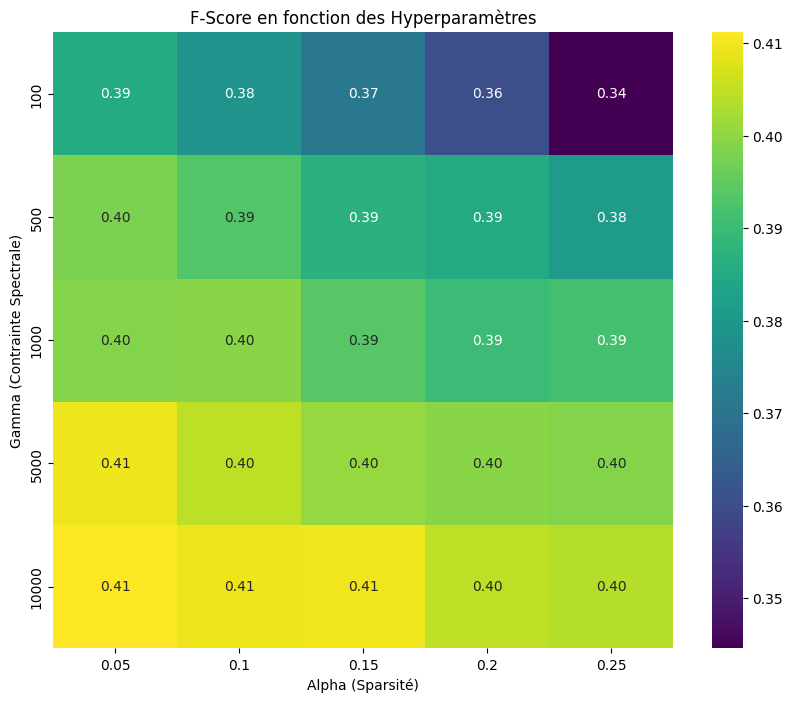

MEILLEURS PARAMÈTRES TROUVÉS : Alpha=0.05, Gamma=10000.0
Meilleur F-Score : 0.4112
Relancement du meilleur modèle pour visualisation...


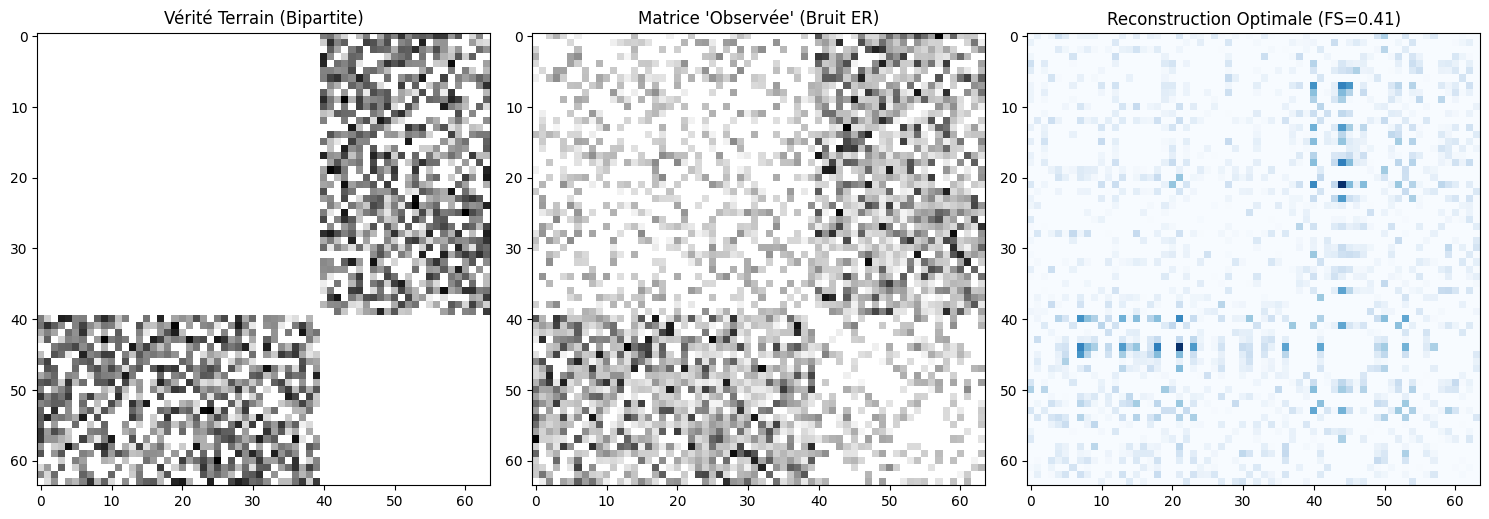

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import networkx as nx
from scipy.linalg import pinv

# --- 1. PRÉPARATION DES DONNÉES (Fixe) ---
# On génère une seule instance difficile pour trouver les meilleurs params dessus
print("Génération des données bruitées (Scenario Fig. 16)...")

n1, n2 = 40, 24
p = n1 + n2
n_samples = 500

# Ground Truth Biparti
G_bi = nx.bipartite.random_graph(n1, n2, p=0.70, seed=42)
W_bi = nx.to_numpy_array(G_bi)
weights_bi = np.random.uniform(0.1, 1.0, size=(p, p))
W_bi = W_bi * ((weights_bi + weights_bi.T) / 2.0)

# Bruit ER
G_er = nx.erdos_renyi_graph(p, p=0.35, seed=99)
W_er = nx.to_numpy_array(G_er)
weights_er = np.random.uniform(0.1, 1.0, size=(p, p))
W_noise = W_er * ((weights_er + weights_er.T) / 2.0)

# Total Bruité & Covariance
W_total = W_bi + W_noise
L_noisy = np.diag(np.sum(W_total, axis=1)) - W_total
Theta = L_noisy + 1e-1 * np.eye(p)
Cov = pinv(Theta)
X = np.random.multivariate_normal(np.zeros(p), Cov, size=n_samples)
S_fixed = np.cov(X.T)

# --- 2. DÉFINITION DE LA GRILLE ---
# Alpha : gère le seuillage du bruit (L1). 
# Gamma : gère la force de la structure biparti.
# On teste large car le bruit est fort.
param_grid = {
    'alpha': [0.05, 0.10, 0.15, 0.20, 0.25], 
    'gamma': [100, 500, 1000, 5000, 10000]   
}

results = []

print(f"Lancement du Grid Search ({len(param_grid['alpha']) * len(param_grid['gamma'])} combinaisons)...")

# --- 3. BOUCLE DE RECHERCHE ---
with tqdm(total=len(param_grid['alpha'])*len(param_grid['gamma'])) as pbar:
    for g in param_grid['gamma']:
        for a in param_grid['alpha']:
            
            # Apprentissage
            model = GraphLearningSGA(alpha=a, gamma=g, max_iter=400, tol=1e-4)
            try:
                model.fit(S_fixed)
                
                # Évaluation vs Ground Truth (W_bi)
                W_learned = model.A_.copy()
                W_learned[W_learned < 1e-3] = 0
                
                metrics = evaluate_graph_performance(W_bi, W_learned, threshold=1e-3)
                
                results.append({
                    'alpha': a,
                    'gamma': g,
                    'F_Score': metrics['FS'],
                    'RE': metrics['RE']
                })
            except Exception as e:
                # En cas de divergence
                results.append({'alpha': a, 'gamma': g, 'F_Score': 0, 'RE': np.nan})
            
            pbar.update(1)

# --- 4. ANALYSE ET VISUALISATION ---
df = pd.DataFrame(results)

# Pivot pour la Heatmap
pivot_table = df.pivot(index='gamma', columns='alpha', values='F_Score')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".2f")
plt.title("F-Score en fonction des Hyperparamètres")
plt.xlabel("Alpha (Sparsité)")
plt.ylabel("Gamma (Contrainte Spectrale)")
plt.show()

# --- 5. REPRODUCTION AVEC LE MEILLEUR MODÈLE ---
best_run = df.loc[df['F_Score'].idxmax()]
print("="*50)
print(f"MEILLEURS PARAMÈTRES TROUVÉS : Alpha={best_run['alpha']}, Gamma={best_run['gamma']}")
print(f"Meilleur F-Score : {best_run['F_Score']:.4f}")
print("="*50)

print("Relancement du meilleur modèle pour visualisation...")
best_model = GraphLearningSGA(
    alpha=best_run['alpha'], 
    gamma=best_run['gamma'], 
    max_iter=1000, 
    tol=1e-5
)
best_model.fit(S_fixed)

# Visualisation type Figure 16
plt.figure(figsize=(15, 5))

# A. Vérité
plt.subplot(1, 3, 1)
plt.title("Vérité Terrain (Bipartite)")
plt.imshow(W_bi, cmap='Greys')

# B. Entrée (Bruitée)
plt.subplot(1, 3, 2)
plt.title("Matrice 'Observée' (Bruit ER)")
plt.imshow(W_total, cmap='Greys')

# C. Résultat Optimisé
plt.subplot(1, 3, 3)
plt.title(f"Reconstruction Optimale (FS={best_run['F_Score']:.2f})")
W_final = best_model.A_.copy()
# Petit seuillage pour l'esthétique du plot (retirer les 1e-10)
W_final[W_final < 0.01] = 0 
plt.imshow(W_final, cmap='Blues')

plt.tight_layout()
plt.show()